# Task lab work # 4
# Yuliia Shevchenko
# CS32
# Dataset

# 1. Chose the dataset with images (FOR CLASSIFICATION) from sugessted or you could prepare own (find in kaggle or create).
Created own dataset gives additional points in the final mark (100-200 images on each class).

## Links on Datasets
* [Cats Vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs)
* [caltech101: classification of 101 instances](https://www.tensorflow.org/datasets/catalog/caltech101)
* [same as above but with birds](https://www.tensorflow.org/datasets/catalog/caltech_birds2010)
* [with birds v2](https://www.tensorflow.org/datasets/catalog/caltech_birds2011)
* [cars classification](https://www.tensorflow.org/datasets/catalog/cars196)
* [plant disease classification](https://www.tensorflow.org/datasets/catalog/cassava)
* [CIFAR100: classification of 100 instances of types](https://www.tensorflow.org/datasets/catalog/cifar100)
* [Healthy and Unhealthy citrus leaves](https://www.tensorflow.org/datasets/catalog/citrus_leaves)

# 2. Train the same data (but with different data preparation stages) for Convolutional and Fullyconnected NNs.
0. Prepare you data, download into folders, preproces, rescale, etc.
1. Train fullyconnected NN on your selected dataset in the similar manner to example
2. Train convolutional NN on your selected dataset in the similar manner to example

In [8]:
!pip install --upgrade pip

In [7]:
!pip install tensorflow_datasets


In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

In [23]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar100',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

class_names = ds_info.features['label'].names
NUM_CLASSES = ds_info.features['label'].num_classes


In [24]:
num_classes = len(class_names)
print(f"Кількість класів: {num_classes}")
print(f"Перші 20 класів: {class_names[:20]}")

Кількість класів: 100
Перші 20 класів: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle']


In [25]:
IMG_SIZE = 32
BATCH_SIZE = 64
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(tf.cast(label, tf.int32), NUM_CLASSES)
    return image, label

train_size = int(0.85 * 50000)
ds_val = ds_train.skip(train_size)
ds_train = ds_train.take(train_size)

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(lambda x, y: (data_augmentation(x, training=True), y))
ds_train = ds_train.shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


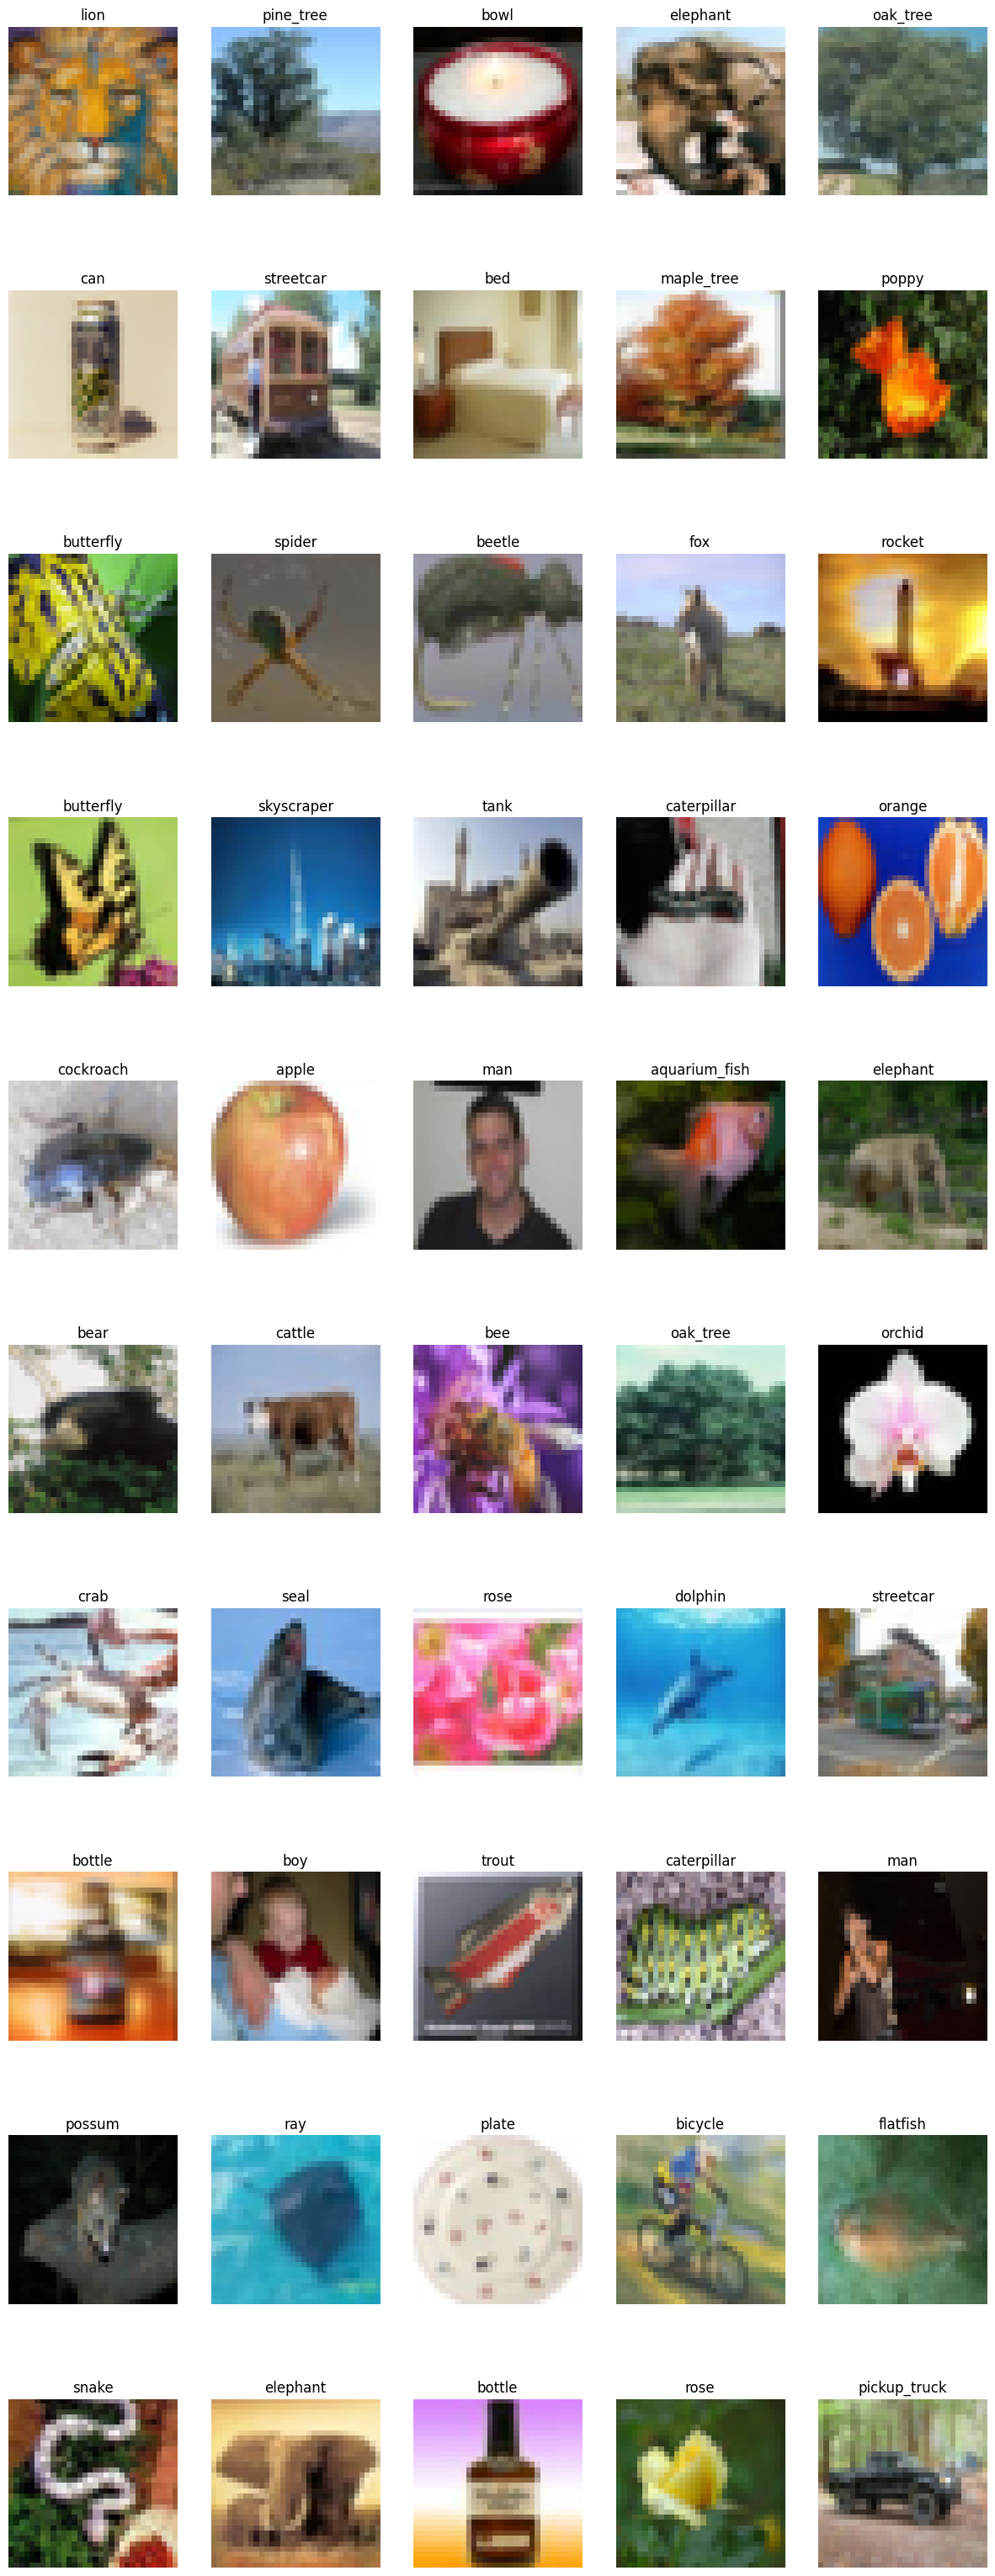

In [26]:
ds_test_vis = ds_test.unbatch().take(50)

plt.figure(figsize=(15, 40))
for i, (image, label) in enumerate(ds_test_vis):
    ax = plt.subplot(10, 5, i + 1)
    plt.imshow(image.numpy())
    class_idx = int(tf.argmax(label).numpy())
    plt.title(class_names[class_idx])
    plt.axis("off")
plt.show()


In [27]:
model = Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # Block 1
    layers.Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    # Block 2
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),

    # Block 3
    layers.Conv2D(256, 3, padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, 3, padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),

    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(NUM_CLASSES, activation='softmax')
])


In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 8, 8, 256)      │             

 Total params: 1,440,676 (5.50 MB)

 Trainable params: 1,437,348 (5.48 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

In [29]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 283s 416ms/step - accuracy: 0.0208 - loss: 6.3018 - val_accuracy: 0.0448 - val_loss: 5.7048 - learning_rate: 1.0000e-04
Epoch 2/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 274s 411ms/step - accuracy: 0.0483 - loss: 5.7308 - val_accuracy: 0.0844 - val_loss: 5.2951 - learning_rate: 1.0000e-04
Epoch 3/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 261s 391ms/step - accuracy: 0.0683 - loss: 5.4293 - val_accuracy: 0.0971 - val_loss: 5.1307 - learning_rate: 1.0000e-04
Epoch 4/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 267s 400ms/step - accuracy: 0.0844 - loss: 5.2082 - val_accuracy: 0.1227 - val_loss: 4.9254 - learning_rate: 1.0000e-04
Epoch 5/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 279s 418ms/step - accuracy: 0.0976 - loss: 5.0028 - val_accuracy: 0.1356 - val_loss: 4.7632 - learning_rate: 1.0000e-04
Epoch 6/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 285s 428ms/step - accuracy: 0.1077 - loss: 4.8421 - val_accuracy: 0.1536 - val_loss: 4.5445 - learning_rate: 1.0000e-04
Epoch 7/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 

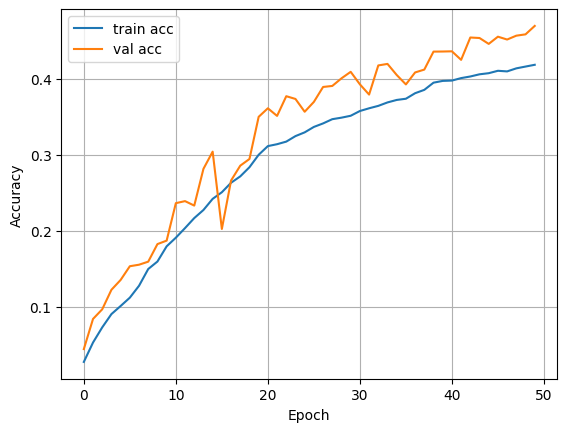

In [31]:
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


In [32]:
loss, acc = model.evaluate(ds_test)
print(f"Test Accuracy: {acc:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.4855 - loss: 2.2614
Test Accuracy: 0.4791


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


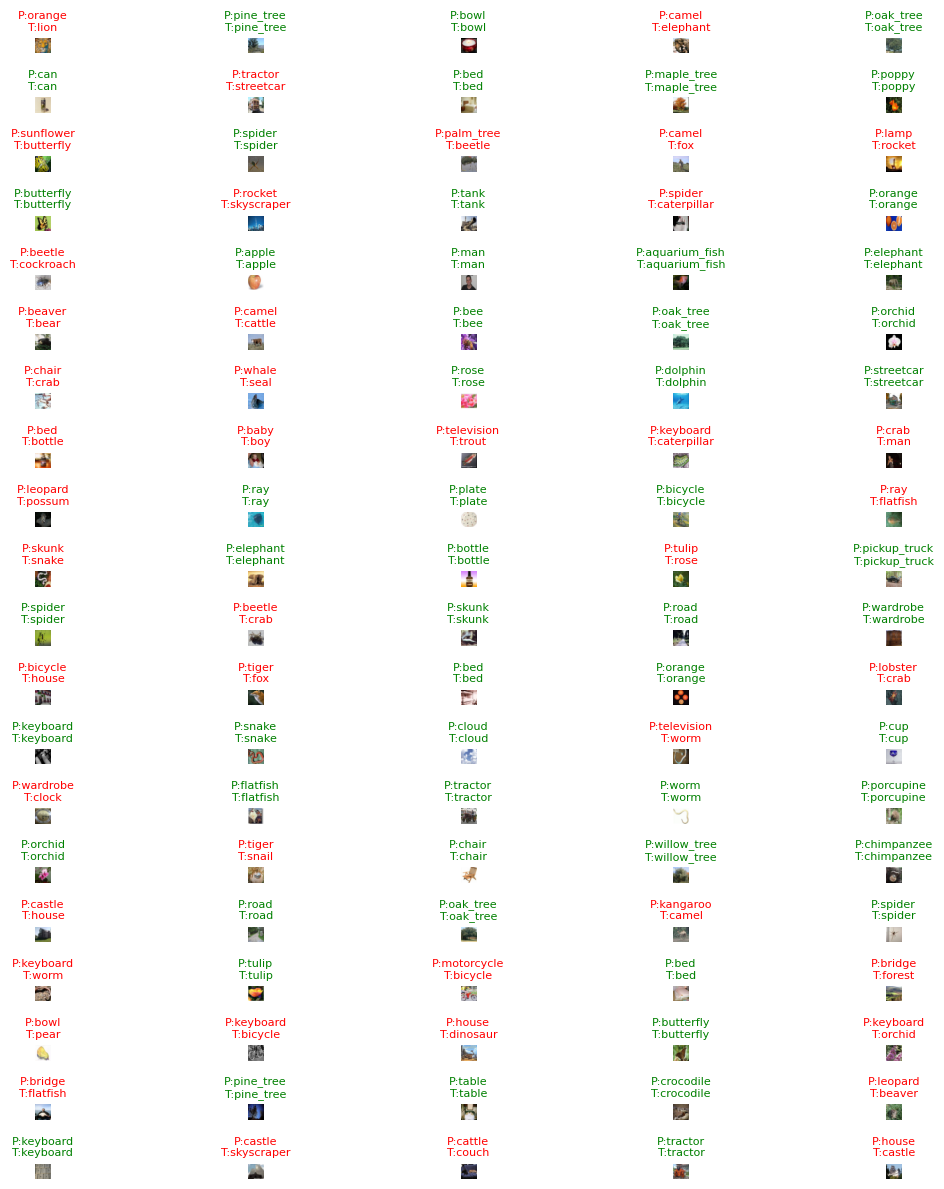

In [34]:
# Снимем батчи, нормализуем и подготовим тестовые данные
x_test, y_test = [], []
for img, label in ds_test.unbatch().take(1000):  # можно взять сколько хочешь, например 1000
    x_test.append(img.numpy())
    y_test.append(label.numpy())

x_test = np.array(x_test)
y_test = np.array(y_test)

# Предсказания модели
predictions = model.predict(x_test)

# Визуализация первых 25 результатов
plt.figure(figsize=(12, 12))
for idx in range(100):
    plt.subplot(20, 5, idx + 1)
    plt.imshow(x_test[idx])
    pred_label = np.argmax(predictions[idx])
    true_label = np.argmax(y_test[idx])
    plt.title(f"P:{class_names[pred_label]}\nT:{class_names[true_label]}", fontsize=8,
              color="green" if pred_label == true_label else "red")
    plt.axis("off")
plt.tight_layout()
plt.show()
